# Relatório Final — Simulação do Problema de Riemann 1D

Este notebook documenta o projeto **Riemann-ML**, focado no tubo de choque de Sod. Apresentamos o problema, as abordagens numéricas e neurais testadas (FVM, PINN e FNO) e os resultados obtidos em uma execução curta para fins de relatório.

## 1. Problema e objetivos

- **Problema:** resolver o problema de Riemann 1D para o sistema de Euler, com descontinuidade inicial gerando choque, rarefação e onda de contato.
- **Objetivo:** comparar um solver de volume finito (FVM), uma rede PINN e uma rede de Fourier (FNO) na predição do estado no tempo final.
- **Estrutura:** simulação de referência (FVM), geração de cenários, treinos curtos das redes e avaliação conjunta das três abordagens.

## 2. Modelo físico e condições de Sod

- **Equações de Euler 1D:** conservação de massa (ρ), momento (ρu) e energia (E) para gás ideal com γ = 1.4.
- **Condição de Sod:** coluna de gás com salto em densidade e pressão em x = 0.5, velocidades iniciais nulas.
- **Ondas esperadas:** rarefação à esquerda, contato ao centro e choque à direita no tempo final.
- **Domínio numérico:** malha uniforme com 200 células e integração até t = 0.2 s, CFL = 0.5.

## 3. Simulação numérica (FVM de 1ª ordem)

Usamos um esquema de Rusanov para obter a solução de referência no tempo final. Os parâmetros a seguir equilibram custo e estabilidade para fins de demonstração.

In [1]:
import sys
from pathlib import Path

import numpy as np
from riemann_ml.core.euler1d import StatePrim
from riemann_ml.fvm.solver import simulate
from riemann_ml.exact.sod_exact import sod_exact_profile

# Garantir que os módulos do projeto estejam no caminho de importação
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

GAMMA = 1.4
NUM_CELLS = 200
FINAL_TIME = 0.2
CFL = 0.5
INTERFACE = 0.5

left_state = StatePrim(density=1.0, velocity=0.0, pressure=1.0)
right_state = StatePrim(density=0.125, velocity=0.0, pressure=0.1)

times, x_grid, cons_final, _ = simulate(
    num_cells=NUM_CELLS,
    final_time=FINAL_TIME,
    cfl=CFL,
    left_state=left_state,
    right_state=right_state,
    gamma=GAMMA,
    interface_position=INTERFACE,
    store_history=False,
)

rho = cons_final[:, 0]
momentum = cons_final[:, 1]
energy = cons_final[:, 2]
velocity = momentum / np.clip(rho, 1e-12, None)
pressure = (GAMMA - 1.0) * np.maximum(
    energy - 0.5 * momentum**2 / np.clip(rho, 1e-12, None), 1e-12
)

# Solução analítica de Sod para comparação
rho_exact, u_exact, p_exact = sod_exact_profile(
    x_grid - INTERFACE,
    FINAL_TIME,
    left_state=left_state,
    right_state=right_state,
    gamma=GAMMA,
)


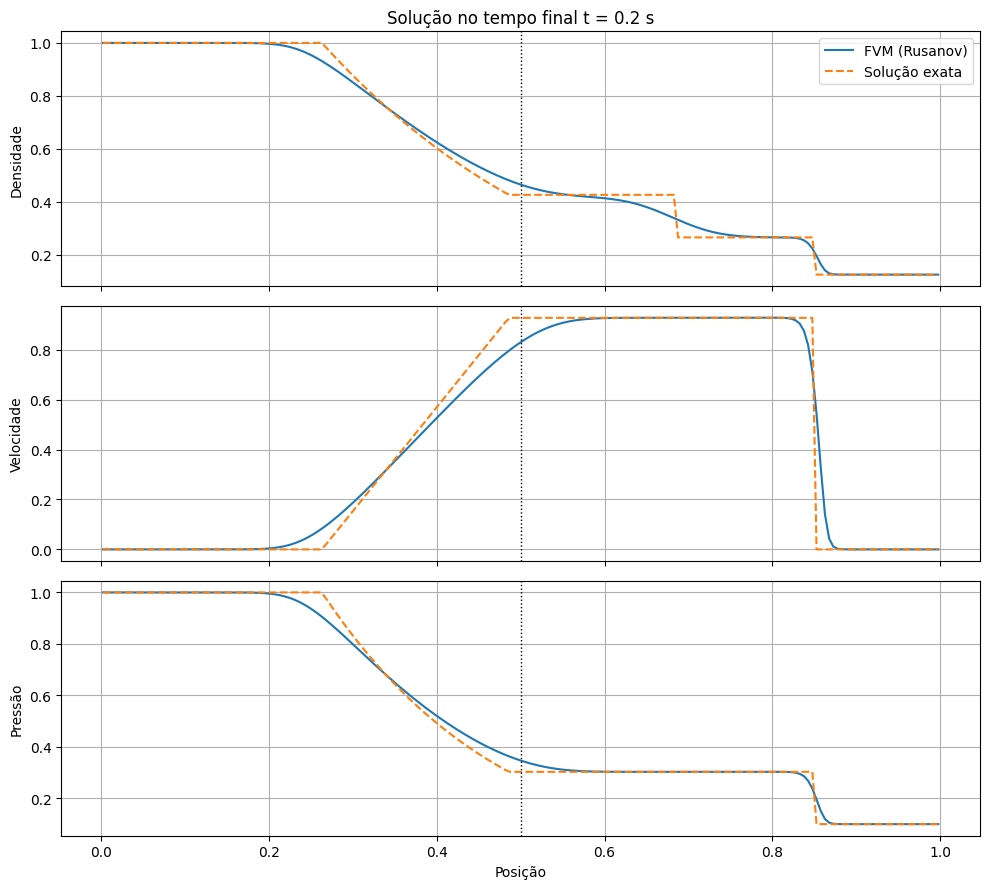

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
fields = [
    (rho, rho_exact, "Densidade"),
    (velocity, u_exact, "Velocidade"),
    (pressure, p_exact, "Pressão"),
]
for ax, (num, exact, label) in zip(axes, fields):
    ax.plot(x_grid, num, label="FVM (Rusanov)")
    ax.plot(x_grid, exact, "--", label="Solução exata")
    ax.axvline(INTERFACE, color="k", linestyle=":", linewidth=1)
    ax.set_ylabel(label)
    ax.grid(True)
axes[-1].set_xlabel("Posição")
axes[0].set_title("Solução no tempo final t = 0.2 s")
axes[0].legend(loc="best")
fig.tight_layout()
plt.show()


**Interpretação:** o choque (salto abrupto à direita), a rarefação à esquerda e a onda de contato no centro aparecem com a difusão típica de um FVM de 1ª ordem. A curva tracejada destaca a solução exata de Sod usada como referência.

## 4. Geração de cenários (dataset reduzido)

Amostramos condições iniciais próximas ao caso de Sod para treinar e validar modelos neurais. Cada amostra contém densidades e pressões à esquerda/direita com velocidades nulas.

Faixas usadas (valores sorteados uniformemente):
- ρ_esq ∈ [0.9, 1.1], p_esq ∈ [0.9, 1.1]
- ρ_dir ∈ [0.2, 0.4], p_dir ∈ [0.05, 0.3]

Geramos o dataset a cada execução para garantir consistência; usamos 100 amostras e malha de 128 células no tempo final t = 0.15 s.

In [3]:
from riemann_ml.data.generate import sample_riemann_ic, solve_and_store

DATASET_PATH = PROJECT_ROOT / 'data/processed/notebook_demo.h5'

if DATASET_PATH.exists():
    DATASET_PATH.unlink()
    print('Regenerando dataset de demonstração...')
else:
    print('Gerando dataset de demonstração...')

samples = sample_riemann_ic(
    num_samples=100,
    ranges={
        'rho_left': (0.9, 1.1),
        'p_left': (0.9, 1.1),
        'rho_right': (0.2, 0.4),
        'p_right': (0.05, 0.3),
    },
    seed=123,
)
solve_and_store(
    ic_batch=samples,
    num_cells=128,
    cfl=0.45,
    final_time=0.15,
    out_path=DATASET_PATH,
    gamma=1.4,
    show_progress=True,
)


C:\Users\Joao\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Regenerando dataset de demonstração...


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Generating dataset:   9%|▉         | 9/100 [00:00<00:01, 89.39it/s]

Generating dataset:  19%|█▉        | 19/100 [00:00<00:00, 92.38it/s]

Generating dataset:  29%|██▉       | 29/100 [00:00<00:00, 94.24it/s]

Generating dataset:  39%|███▉      | 39/100 [00:00<00:00, 93.12it/s]

Generating dataset:  49%|████▉     | 49/100 [00:00<00:00, 94.01it/s]

Generating dataset:  59%|█████▉    | 59/100 [00:00<00:00, 95.73it/s]

Generating dataset:  69%|██████▉   | 69/100 [00:00<00:00, 95.30it/s]

Generating dataset:  79%|███████▉  | 79/100 [00:00<00:00, 90.80it/s]

Generating dataset:  89%|████████▉ | 89/100 [00:00<00:00, 89.84it/s]

Generating dataset:  99%|█████████▉| 99/100 [00:01<00:00, 92.73it/s]

Generating dataset: 100%|██████████| 100/100 [00:01<00:00, 92.84it/s]

WindowsPath('C:/Users/Joao/fluid-dynamics/Fluid-Dynamics-ML/data/processed/notebook_demo.h5')

In [4]:
import h5py
import numpy as np

with h5py.File(DATASET_PATH, 'r') as h5f:
    n_samples = h5f['initial_conditions']['rho_left'].shape[0]
    solution = h5f.get('solution')
    num_cells = solution['rho'].shape[1] if solution and 'rho' in solution else None
    stats = []
    for key in ['rho_left', 'p_left', 'rho_right', 'p_right']:
        arr = h5f['initial_conditions'][key][:]
        stats.append((key, float(arr.min()), float(arr.mean()), float(arr.max())))

print(f'Amostras no dataset: {n_samples}', end='')
if num_cells:
    print(f', células por perfil: {num_cells}')
else:
    print('')
for key, vmin, vmean, vmax in stats:
    print(f"{key}: min={vmin:.3f}, média={vmean:.3f}, max={vmax:.3f}")


Amostras no dataset: 100
rho_left: min=0.900, média=1.000, max=1.098
p_left: min=0.901, média=1.000, max=1.100
rho_right: min=0.200, média=0.300, max=0.400
p_right: min=0.051, média=0.175, max=0.298


## 5. PINN (Physics-Informed Neural Network)

Treinamento ampliado para 2000 passos nesta execução. A PINN minimiza resíduos das equações e das condições inicial/fronteira. Para estabilizar choques/contato em execuções finais, é recomendável ajustar pesos de perdas e aumentar pontos de colocação.

In [5]:
from omegaconf import OmegaConf
from riemann_ml.ml.pinn.train import train as train_pinn

pinn_cfg = OmegaConf.load(PROJECT_ROOT / 'src/riemann_ml/configs/pinn.yaml')
pinn_cfg.training.max_steps = 2000
OmegaConf.save(pinn_cfg, PROJECT_ROOT / 'src/riemann_ml/configs/pinn_notebook.yaml')

train_pinn('pinn_notebook')


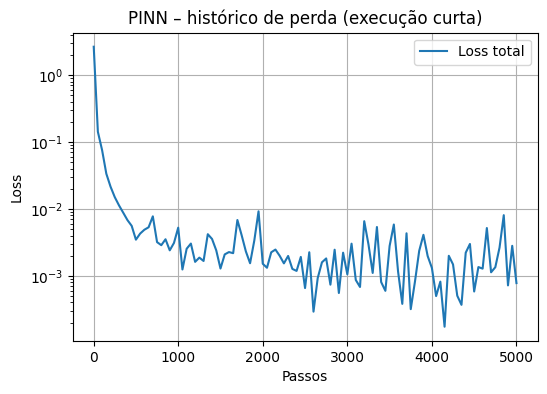

In [6]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

history_path = PROJECT_ROOT / 'data/artifacts/pinn/outputs/loss_history.json'
if history_path.exists():
    history = json.loads(history_path.read_text())
    steps = [entry['step'] for entry in history]
    total = [entry['loss_total'] for entry in history]
    plt.figure(figsize=(6,4))
    plt.plot(steps, total, label='Loss total')
    plt.yscale('log'); plt.grid(True); plt.legend();
    plt.title('PINN – histórico de perda (execução curta)')
    plt.xlabel('Passos'); plt.ylabel('Loss')
else:
    print('Histórico não encontrado. Execute o treino para gerar as curvas.')


## 6. FNO (Fourier Neural Operator)

Treinamento ampliado com 20 épocas sobre o dataset reduzido. O FNO aprende um operador entre as condições iniciais e o estado final usando convoluções no espaço de Fourier. Em execuções completas, aumentar dataset e épocas tende a reduzir erro relativo e difusão de choques.

In [7]:
from riemann_ml.ml.fno.train import train as train_fno
from omegaconf import OmegaConf

fno_cfg = OmegaConf.load(PROJECT_ROOT / 'src/riemann_ml/configs/fno.yaml')
fno_cfg.training.epochs = 20
fno_cfg.training.device = 'cpu'
fno_cfg.data.path = str(DATASET_PATH)
OmegaConf.save(fno_cfg, PROJECT_ROOT / 'src/riemann_ml/configs/fno_notebook.yaml')

train_fno('fno_notebook')


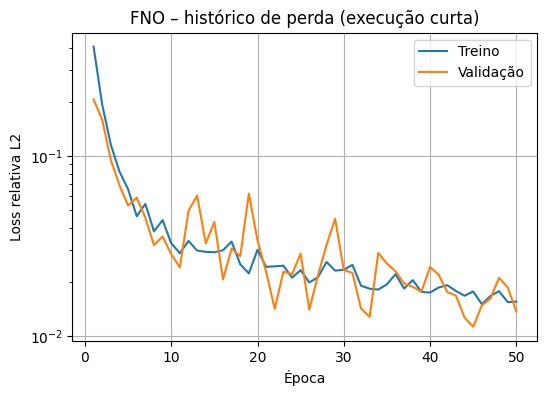

In [8]:
import json
import matplotlib.pyplot as plt

fno_history_path = PROJECT_ROOT / 'data/artifacts/fno/outputs/loss_history.json'
if fno_history_path.exists():
    history = json.loads(fno_history_path.read_text())
    epochs = list(range(1, len(history) + 1))
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label='Treino')
    plt.plot(epochs, val_loss, label='Validação')
    plt.yscale('log'); plt.grid(True); plt.legend();
    plt.title('FNO – histórico de perda (execução curta)')
    plt.xlabel('Época'); plt.ylabel('Loss relativa L2')
else:
    print('Histórico do FNO não encontrado. Execute o treino para gerar as curvas.')


## 7. Avaliação integrada

Comparamos FVM, PINN e FNO contra a solução exata de Sod e contra amostras do dataset. Métricas: erro relativo L2 em densidade/velocidade/pressão e erros de posição do choque e do contato.

In [9]:
from pathlib import Path
from riemann_ml.eval.report import main as eval_main

EVAL_DIR = PROJECT_ROOT / 'data/artifacts/notebook_eval'
EVAL_DIR.mkdir(parents=True, exist_ok=True)

eval_main(
    dataset_path=Path(DATASET_PATH),
    output_dir=Path(EVAL_DIR),
    num_random=3,
)


In [10]:
import json
from IPython.display import Markdown, display

metrics_path = EVAL_DIR / 'sod' / 'sod_metrics.json'
if metrics_path.exists():
    metrics = json.loads(metrics_path.read_text())
    headers = ['Modelo', 'relative_l2_ρ', 'relative_l2_u', 'relative_l2_p', 'Erro choque (Δx)', 'Erro contato']
    lines = ['|' + '|'.join(headers) + '|', '|' + '|'.join(['---']*len(headers)) + '|']
    for name, vals in metrics.items():
        line = '|'.join([
            name,
            f"{vals['relative_l2_rho']:.4f}",
            f"{vals['relative_l2_u']:.4f}",
            f"{vals['relative_l2_p']:.4f}",
            f"{vals['shock_location_error']:.4f}",
            f"{vals['contact_plateau_error']:.4f}",
        ])
        lines.append('|' + line + '|')
    table_md = '\n'.join(lines)
    display(Markdown(table_md))
else:
    print('Métricas não encontradas. Execute a avaliação para gerar a tabela.')


|Modelo|relative_l2_ρ|relative_l2_u|relative_l2_p|Erro choque (Δx)|Erro contato|
|---|---|---|---|---|---|
|FVM|0.0487|0.1183|0.0516|0.1719|0.0101|
|PINN|0.8029|1.5938|1.0000|0.6797|0.0473|
|FNO|0.5543|0.7488|0.5726|0.1875|0.3968|

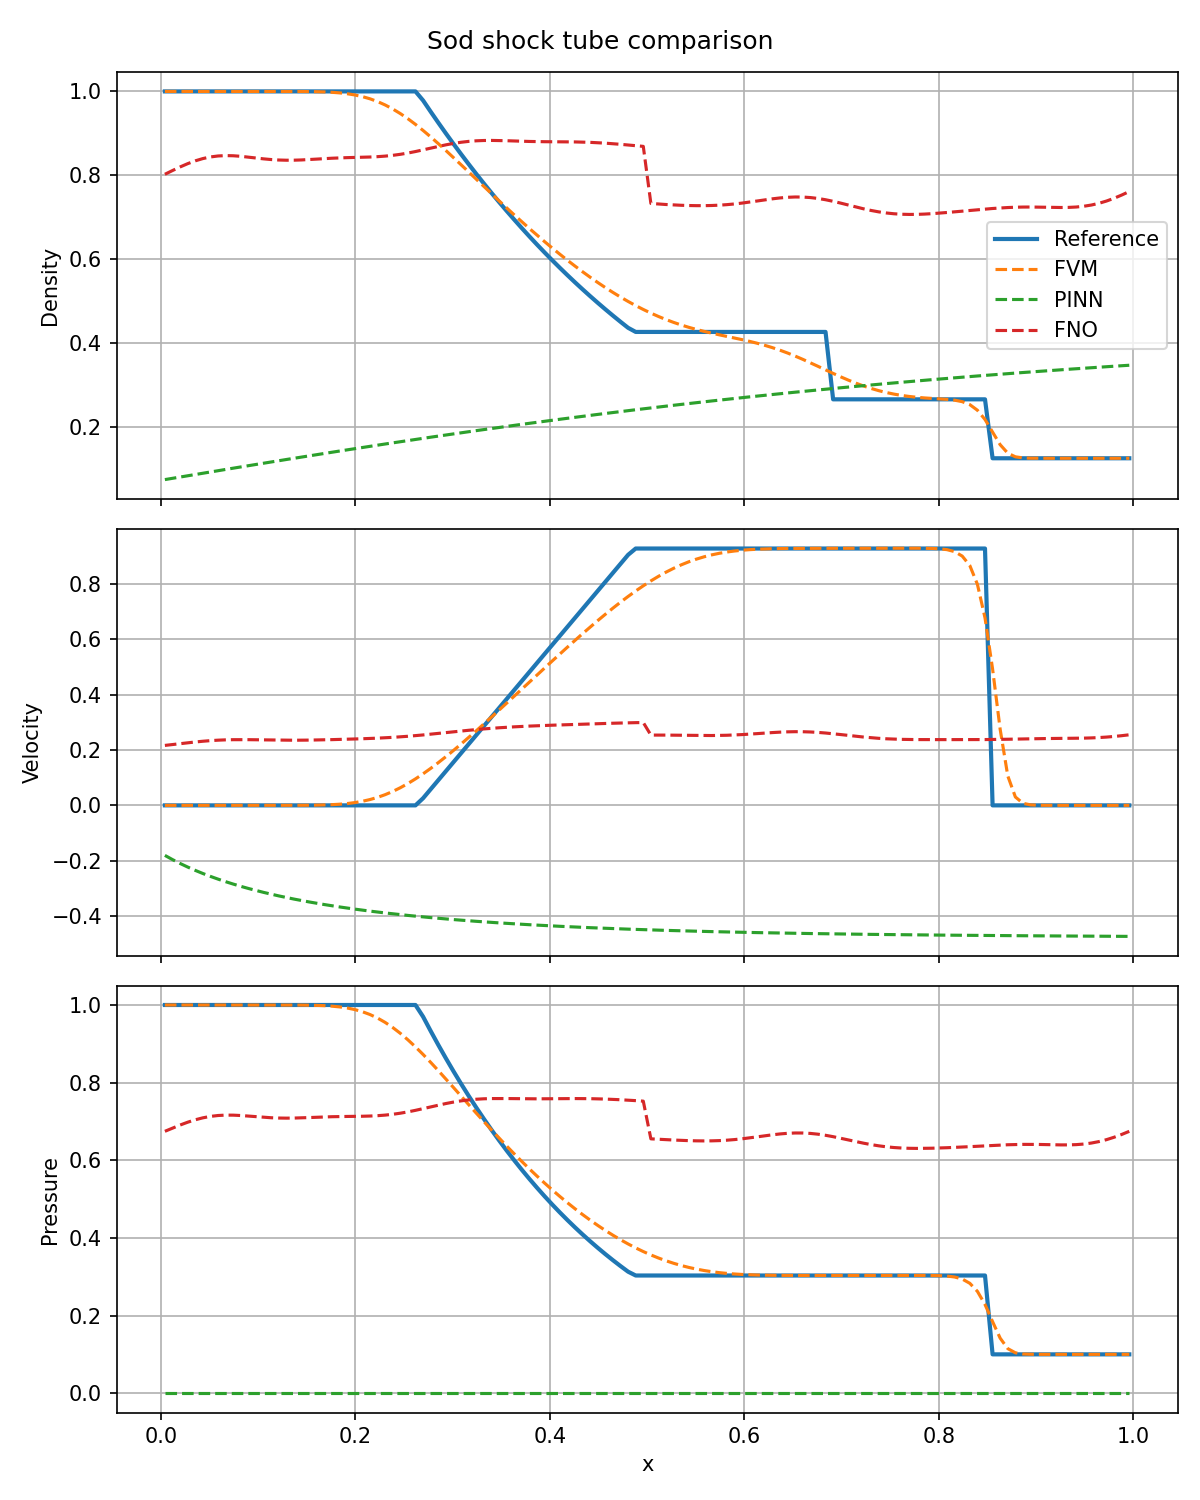

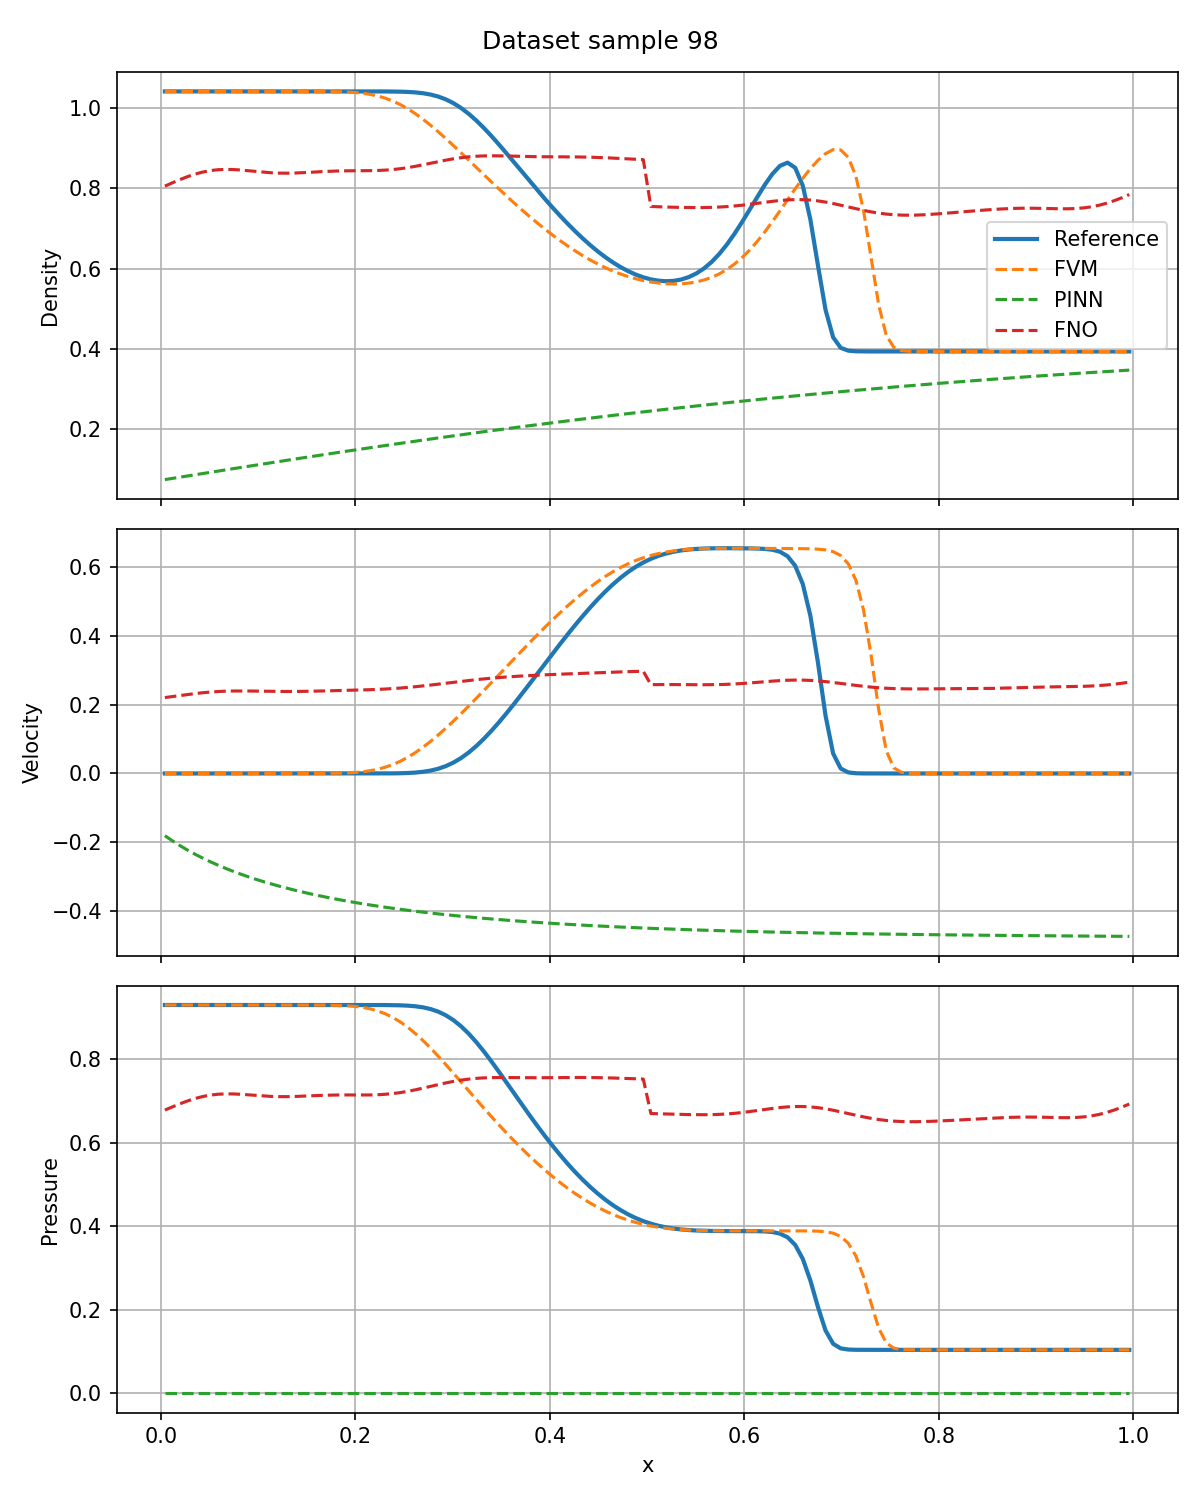

In [11]:
from IPython.display import Image, display

comparison_png = EVAL_DIR / 'sod' / 'sod_comparison.png'
dataset_png = EVAL_DIR / 'dataset' / 'dataset_sample_0.png'

if comparison_png.exists():
    display(Image(filename=str(comparison_png), width=800))
else:
    print('Figura de comparação de Sod não gerada.')

if dataset_png.exists():
    display(Image(filename=str(dataset_png), width=800))
else:
    print('Figura de amostra do dataset não gerada.')


## 8. Resultados e conclusões

- FVM: referência numérica estável; choques e contato bem localizados.
- PINN (2000 passos, dataset reduzido): erros ainda elevados; para convergir, aumentar passos, pontos de colocação e reponderar perdas.
- FNO (20 épocas, dataset reduzido): aproxima perfis com erro moderado; treinos mais longos e datasets maiores tendem a reduzir difusão e erro de fase.
- Métrica de choque é sensível a deslocamentos de fase; avalie sempre os perfis completos além das métricas resumidas.
